In [25]:
%load_ext autoreload
%autoreload 2

import pydrake
import torch
import pyro
from pyro import poutine
import time
import matplotlib.pyplot as plt

import scene_generation.data.dataset_utils as dataset_utils
from scene_generation.models.planar_multi_object_multi_class_2_with_context import MultiObjectMultiClassModelWithContext

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import numpy as np
DATA_DIR_TRAIN = "/home/gizatt/projects/scene_generation/data/planar_bin/planar_bin_static_scenes_stacks_tall_train/"
DATA_DIR_TEST = "/home/gizatt/projects/scene_generation/data/planar_bin/planar_bin_static_scenes_stacks_tall_test/"

scenes_dataset_yaml = dataset_utils.ScenesDataset(DATA_DIR_TRAIN)
params_by_object_class = {}
for env_i in range(len(scenes_dataset_yaml)):
    env = scenes_dataset_yaml[env_i]
    for obj_i in range(env["n_objects"]):
        obj_yaml = env["obj_%04d" % obj_i]
        class_name = obj_yaml["class"]
        if class_name not in params_by_object_class.keys():
            params_by_object_class[class_name] = []
        params_by_object_class[class_name].append(obj_yaml["pose"] + obj_yaml["params"])

for object_name in params_by_object_class.keys():
    print object_name, ": "
    params = np.stack(params_by_object_class[object_name])
    print params.shape
    print "means: ", np.mean(params, axis=0)
    print "vars: ", np.std(params, axis=0)

2d_box : 
(7819, 5)
means:  [-0.01102967  0.32073934 -0.02849547  0.200866    0.20438506]
vars:  [0.4484622  0.23035233 1.04938174 0.05754121 0.05745243]
2d_sphere : 
(1105, 4)
means:  [-0.00435995  0.34037243 -0.24383675  0.10027824]
vars:  [0.49857216 0.25986996 3.84608937 0.02914961]


In [27]:
print len(scenes_dataset_yaml)

1368


In [28]:
scenes_dataset = dataset_utils.ScenesDatasetVectorized(DATA_DIR_TRAIN, max_num_objects=20)
data = scenes_dataset.get_full_dataset()

scenes_dataset_test = dataset_utils.ScenesDatasetVectorized(DATA_DIR_TEST, max_num_objects=20)
data_test = scenes_dataset_test.get_full_dataset()

print "Train # batches: ", data.batch_size
print "Test # batches: ", data_test.batch_size

Train # batches:  1368
Test # batches:  342


In [29]:
# Rig for SVI, running with AutoDelta, which converges fairly reliably but
# confuses the variances
from collections import defaultdict
from torch.distributions import constraints
from pyro.infer import Trace_ELBO, SVI
from pyro.contrib.autoguide import AutoDelta, AutoDiagonalNormal, AutoMultivariateNormal, AutoGuideList
import datetime
from tensorboardX import SummaryWriter

pyro.enable_validation(True)

log_dir = "/home/gizatt/projects/scene_generation/models/runs/pmomc2/" + datetime.datetime.now().strftime(
    "%Y-%m-%d-%H-%m-%s")
writer = SummaryWriter(log_dir)
def write_np_array(writer, name, x, i):
    for yi, y in enumerate(x):
        writer.add_scalar(name + "/%d" % yi, y, i)
        
print "All params: ", pyro.get_param_store().get_all_param_names()
#interesting_params = ["keep_going_weights",
#                      "new_class_weights"]

model = MultiObjectMultiClassModelWithContext(scenes_dataset)
pyro.clear_param_store()
pyro.get_param_store().save("planar_multi_object_multi_class_2_with_context_stacks_untrained.pyro")
guide = AutoDelta(poutine.block(model.model, hide=["obs"]))

optim = pyro.optim.Adam({'lr': 0.01, 'betas': [0.9, 0.99]})
elbo = Trace_ELBO(max_plate_nesting=1)
svi = SVI(model.model, guide, optim, loss=elbo)
losses = []
losses_test = []
best_on_test_loss = 0
best_test_loss = np.infty
cycles_since_improvement = 0

snapshots = {}
for i in range(501):
    # Guesses on important things:
    # Big subsamples appear really important -- I had major loss of
    # convergence when using smaller subsample sizes (like ~50).
    # Also important: prior on the variance must be REALLY low.
    # Otherwise long_box_mean diverges to negative... :(
    # I think there's a fundamental problem with variance estimation
    # under this guide / with this system -- see the single-box-dataset
    # estimates that don't capture the x vs y variance.
    loss = svi.step(data, subsample_size=250) / data.batch_size
    losses.append(loss)
    writer.add_scalar('loss', loss, i)

    loss_test = svi.evaluate_loss(data_test, subsample_size=25) / data_test.batch_size
    losses_test.append(loss_test)
    writer.add_scalar('loss_test', loss_test, i)

    if loss_test < best_test_loss:
        best_on_test_loss = pyro.get_param_store().get_state()
        best_test_loss = loss_test
        cycles_since_improvement = 0
    else:
        cycles_since_improvement += 1
        if cycles_since_improvement > 10:
            print("Terminating early due to rising test loss")
            break

    #for p in interesting_params:
    #    write_np_array(writer, p, snapshots[p][-1], i)
    if (i % 10 == 0):
        print loss, best_test_loss
print "Done"

All params:  ['class_vars_generator_module_0$$$0.bias', 'class_means_generator_module_0$$$0.weight', 'keep_going_controller_module$$$2.weight', 'class_means_generator_module_0$$$2.weight', 'class_vars_generator_module_1$$$0.weight', 'class_vars_generator_module_1$$$4.weight', 'class_controller_module$$$4.weight', 'class_controller_module$$$0.weight', 'context_updater_module$$$weight_hh_l0', 'class_vars_generator_module_0$$$0.weight', 'keep_going_controller_module$$$2.bias', 'class_encoder_module_1$$$0.bias', 'class_vars_generator_module_1$$$4.bias', 'context_updater_module$$$bias_hh_l0', 'class_encoder_module_1$$$4.bias', 'class_vars_generator_module_0$$$4.weight', 'class_vars_generator_module_1$$$2.bias', 'class_means_generator_module_1$$$2.bias', 'class_means_generator_module_0$$$2.bias', 'context_updater_module$$$weight_ih_l0', 'class_means_generator_module_0$$$0.bias', 'class_encoder_module_0$$$2.weight', 'class_controller_module$$$0.bias', 'class_vars_generator_module_1$$$2.weight

In [30]:
# Load in best state
print("Before state: ", pyro.get_param_store().get_state())
pyro.get_param_store().set_state(best_on_test_loss)
model = MultiObjectMultiClassModelWithContext(scenes_dataset)
print("After state: ", pyro.get_param_store().get_state())

('Before state: ', {'params': {'class_vars_generator_module_0$$$0.bias': Parameter containing:
tensor([-0.1799, -0.3597,  0.4785, -0.2440,  0.3805, -0.1432,  0.3228,  0.4036,
        -0.1748, -0.0537,  0.1960, -0.2479, -0.1552, -0.2680, -0.0658,  0.1739,
         0.2151,  0.1955,  0.3351,  0.1530, -0.2185,  0.1354,  0.2456,  0.1733,
        -0.1010,  0.0638, -0.1703,  0.2754,  0.3272, -0.3309, -0.2274, -0.2338,
        -0.2082, -0.2618, -0.1095, -0.0232,  0.3215, -0.0863,  0.3108, -0.2674,
         0.2881,  0.3534,  0.0444,  0.1851, -0.0927,  0.1760, -0.1060, -0.2036,
         0.2523, -0.1685], requires_grad=True), 'class_means_generator_module_0$$$0.weight': Parameter containing:
tensor([[-2.0530e-01,  4.4428e-02,  1.4521e-01, -9.5255e-03,  1.5823e-01,
          1.7818e-01,  1.0426e-01, -2.0498e-01,  2.0466e-01,  2.6163e-01],
        [ 2.3881e-01,  3.7110e-02, -4.3174e-02, -3.4227e-02,  2.5666e-01,
          1.1614e-01,  1.8036e-02, -2.4535e-01,  2.9582e-01,  3.0819e-01],
        [ 6.

In [31]:
# Save model
# This isn't working and I'm not sure why...
print pyro.get_param_store().get_all_param_names()
pyro.get_param_store().save("planar_multi_object_multi_class_2_with_context_stacks_unstructured.pyro")

['class_vars_generator_module_0$$$0.bias', 'class_means_generator_module_0$$$0.weight', 'keep_going_controller_module$$$2.weight', 'class_means_generator_module_0$$$2.weight', 'class_vars_generator_module_1$$$0.weight', 'class_vars_generator_module_1$$$4.weight', 'class_controller_module$$$4.weight', 'class_controller_module$$$0.weight', 'context_updater_module$$$weight_hh_l0', 'keep_going_controller_module$$$0.weight', 'keep_going_controller_module$$$2.bias', 'class_encoder_module_1$$$0.bias', 'class_vars_generator_module_1$$$4.bias', 'context_updater_module$$$weight_ih_l0', 'class_encoder_module_1$$$4.bias', 'class_vars_generator_module_0$$$4.weight', 'class_vars_generator_module_1$$$2.bias', 'class_means_generator_module_1$$$2.bias', 'class_means_generator_module_0$$$2.bias', 'context_updater_module$$$bias_hh_l0', 'class_means_generator_module_0$$$0.bias', 'class_encoder_module_0$$$2.weight', 'class_controller_module$$$0.bias', 'class_vars_generator_module_1$$$2.weight', 'class_cont

In [32]:
# Load model
pyro.clear_param_store()
pyro.get_param_store().load("planar_multi_object_multi_class_2_with_context_stacks_unstructured.pyro")
model = MultiObjectMultiClassModelWithContext(scenes_dataset)
model.model()

(VectorizedEnvironments(batch_size=1, keep_going=tensor([[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1]],
        dtype=torch.uint8), classes=tensor([[0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]]), params_by_class=[tensor([[[-3.9095e-01,  1.7387e-01,  2.2332e-01,  2.0970e-01,  2.0223e-01],
          [-3.2008e-03,  5.0374e-01,  1.8340e-01,  2.5644e-01,  1.5347e-01],
          [-2.7015e-01,  5.3764e-01,  6.2237e-01,  1.8085e-01,  9.9746e-02],
          [-1.5580e-01,  3.4505e-01, -1.8048e-01,  2.1103e-01,  1.7437e-01],
          [ 2.9742e-01,  2.9420e-01,  2.4109e+00,  2.5508e-01,  2.0937e-01],
          [-1.1792e-01,  2.5181e-01, -1.9288e-01,  1.8046e-01,  2.0876e-01],
          [ 7.2342e-02,  1.3872e-01,  5.3619e-01,  3.2706e-01,  2.3718e-01],
          [ 1.3226e-02, -6.4553e-02, -6.7797e-01,  2.4940e-01,  2.5448e-01],
          [-5.1337e-01,  1.8628e-01,  5.8504e-01,  2.5547e-01,  2.6599e-01],
          [-6.4772e-03,  1.1927e-01,  2.5824e-01,  2.0716e-01, 

In [33]:
# Convert that data back to a YAML environment, which is easier to
# handle.
for i in range(10):
    scene_with_most_objects = None
    for k in range(1):
        generated_data, generated_encodings, generated_contexts = model.model()
        scene_yaml = scenes_dataset.convert_vectorized_environment_to_yaml(
            generated_data)
        if scene_with_most_objects is None or scene_yaml[0]["n_objects"] > scene_with_most_objects["n_objects"]:
            scene_with_most_objects = scene_yaml[0]

    print scene_with_most_objects
    dataset_utils.DrawYamlEnvironment(scene_with_most_objects, "planar_bin")
    time.sleep(1.0)

{'obj_0002': {'color': [0.5206534906907934, 0.0, 1.0, 1.0], 'pose': [0.7335659265518188, 0.5875220894813538, -0.8562599420547485], 'params': [0.13039076328277588], 'class': '2d_sphere', 'params_names': ['radius']}, 'obj_0000': {'color': [0.6286333765245644, 0.0, 1.0, 1.0], 'pose': [0.43109095096588135, 0.36401063203811646, 0.6593553423881531], 'params': [0.2700069546699524, 0.22087165713310242], 'class': '2d_box', 'params_names': ['height', 'length']}, 'obj_0001': {'color': [0.7531153421828515, 0.0, 1.0, 1.0], 'pose': [0.7517498731613159, 0.4009299874305725, 0.484841525554657], 'params': [0.27015382051467896, 0.19785483181476593], 'class': '2d_box', 'params_names': ['height', 'length']}, 'n_objects': 3}
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6000...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/
Connected to meshcat-server.
{'obj_0002': {'color': [0.595451958809412, 0.0, 1.0, 1.0], 'pose': [0.0843910202383995, 0.233984053134918

{'obj_0002': {'color': [0.7243662396847159, 0.0, 1.0, 1.0], 'pose': [-0.3440650701522827, 0.2923230528831482, 0.5257738828659058], 'params': [0.3216805160045624, 0.1576242595911026], 'class': '2d_box', 'params_names': ['height', 'length']}, 'obj_0003': {'color': [0.7239046692025499, 0.0, 1.0, 1.0], 'pose': [-0.03897709771990776, 0.671086847782135, -0.27215880155563354], 'params': [0.1729142814874649, 0.23165439069271088], 'class': '2d_box', 'params_names': ['height', 'length']}, 'obj_0000': {'color': [0.560468682292574, 0.0, 1.0, 1.0], 'pose': [0.08358211070299149, 0.09978451579809189, -0.6674848794937134], 'params': [0.249040424823761, 0.17156901955604553], 'class': '2d_box', 'params_names': ['height', 'length']}, 'obj_0001': {'color': [0.6011294482900668, 0.0, 1.0, 1.0], 'pose': [-0.5761051774024963, 0.1950208991765976, -0.2649054527282715], 'params': [0.18903881311416626, 0.16898095607757568], 'class': '2d_box', 'params_names': ['height', 'length']}, 'obj_0004': {'color': [0.7647897

[9, 7, 6, 6, 5, 12, 9, 2, 5, 4, 4, 6, 7, 4, 6, 10, 8, 17, 5, 5, 3, 7, 11, 4, 4, 18, 9, 11, 5, 8, 7, 15, 11, 5, 6, 16, 4, 8, 6, 4, 19, 12, 3, 4, 7, 9, 7, 2, 9, 20, 16, 7, 20, 7, 4, 20, 4, 13, 6, 12, 5, 15, 8, 9, 7, 2, 7, 11, 16, 9, 8, 6, 12, 5, 11, 7, 12, 8, 9, 4, 2, 5, 8, 7, 6, 7, 11, 16, 9, 6, 7, 12, 2, 10, 9, 9, 7, 19, 13, 10, 2, 5, 3, 3, 12, 2, 6, 19, 8, 12, 13, 7, 12, 5, 9, 8, 8, 11, 11, 4, 7, 7, 5, 11, 7, 18, 6, 12, 12, 10, 20, 9, 13, 14, 4, 9, 8, 3, 12, 5, 20, 10, 12, 13, 15, 14, 11, 8, 6, 5, 10, 5, 12, 11, 13, 9, 20, 2, 4, 11, 4, 5, 13, 8, 8, 6, 12, 11, 7, 9, 7, 4, 8, 5, 7, 11, 5, 13, 6, 15, 6, 13, 16, 6, 4, 11, 9, 8, 20, 12, 14, 8, 8, 11, 4, 6, 9, 10, 7, 5, 11, 6, 2, 1, 7, 12, 15, 10, 9, 11, 8, 8, 6, 10, 3, 16, 8, 5, 9, 4, 8, 7, 6, 7, 9, 8, 13, 5, 8, 13, 8, 6, 11, 6, 7, 12, 6, 5, 8, 5, 8, 12, 5, 2, 12, 7, 5, 10, 15, 3, 20, 2, 13, 10, 10, 7, 18, 7, 7, 12, 3, 3, 13, 8, 20, 8, 14, 9, 8, 3, 15, 5, 7, 4, 3, 13, 4, 7, 5, 11, 9, 13, 9, 5, 6, 12, 2, 5, 6, 10, 10, 11, 17, 5, 17, 10, 14,

(array([ 0.,  1., 22., 19., 39., 45., 39., 50., 45., 48., 30., 37., 38.,
        21., 11., 12., 12.,  5.,  9.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 <a list of 19 Patch objects>)

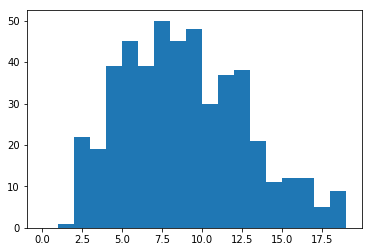

In [138]:
# Convert that data back to a YAML environment, which is easier to
# handle.
generated_n_objs = []
for i in range(500):
    generated_data, generated_encodings, generated_contexts = model.model()
    scene_yaml = scenes_dataset.convert_vectorized_environment_to_yaml(
            generated_data)
    generated_n_objs.append(scene_yaml[0]["n_objects"])
print generated_n_objs
plt.hist(generated_n_objs, bins=range(20))

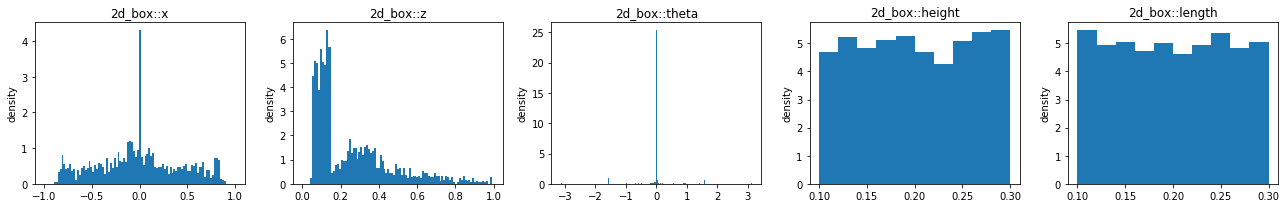

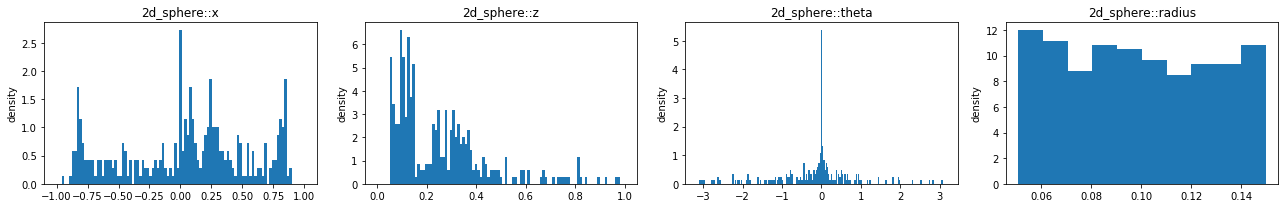

In [81]:
import matplotlib.pyplot as plt
from scipy.stats import norm

for object_name in params_by_object_class.keys():
    object_id = scenes_dataset.class_name_to_id[object_name]
    plt.figure().set_size_inches(18, 3)
    params = np.stack(params_by_object_class[object_name]).copy()
    #params[2, :] = (params[2, :] % np.pi)
    for k in range(params.shape[1]):
        if k >= 3:
            param_name = scenes_dataset.params_names_by_class[object_id][k - 3]
        else:
            param_name = ["x", "z", "theta"][k]
        plt.subplot(1, params.shape[1], k+1)
        plt.title(object_name + "::" + param_name)
        plt.ylabel("density")
        bins = None
        if k == 0:
            bins = np.linspace(-1., 1., 100)
        elif k == 1:
            bins = np.linspace(0., 1., 100)
        elif k == 2:
            bins = np.linspace(-np.pi, np.pi, 200)
        x_bins = plt.hist(params[:, k], label="Empirical", density=True, bins=bins)[1]
        x_range = np.linspace(x_bins[0], x_bins[-1], 100)
        #plt.plot(x_range, norm.pdf(x_range, params_means[k], params_vars[k]), label="Learned")
        
    plt.tight_layout()
    

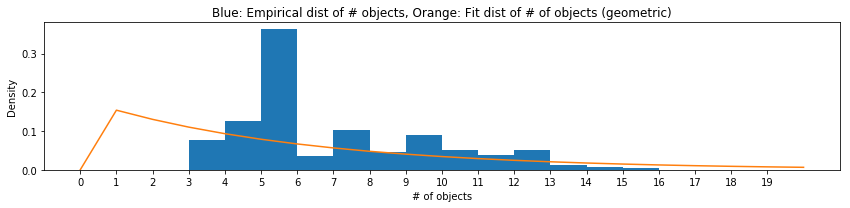

In [54]:
import scipy as sp
import scipy.stats
# Draw the keep_going CDF, which is the product of all previous keep_going vals.
keep_going_vals = pyro.param("keep_going_weights").detach().numpy().copy()
keep_going_pdf = np.zeros(keep_going_vals.shape[0])
for k in range(0, keep_going_pdf.shape[0]):
    keep_going_pdf[k] = np.prod(keep_going_vals[0:k])*(1. - keep_going_vals[k])
plt.figure().set_size_inches(12, 3)
plt.title("Blue: Empirical dist of # objects, Orange: Fit dist of # of objects (geometric)")
plt.xlabel("# of objects")
plt.ylabel("Density")
xbins = plt.hist([p["n_objects"] for p in scenes_dataset_yaml], bins=range(0, 21), density=True)[1]
plt.plot(xbins, sp.stats.geom.pmf(xbins, 1.-keep_going_vals[0]))
plt.xticks(range(20))
plt.tight_layout()

In [19]:
import yaml
noalias_dumper = yaml.dumper.SafeDumper
noalias_dumper.ignore_aliases = lambda self, data: True

while (1):
    generated_data, generated_encodings, generated_contexts = model.model()
    scene_yaml = scenes_dataset.convert_vectorized_environment_to_yaml(
        generated_data)[0]
    try:
        scene_nonpen, scene_static = dataset_utils.ProjectEnvironmentToFeasibility(
            scene_yaml, "planar_bin")

        #print "Scene original"
        #dataset_utils.DrawYamlEnvironment(
        #    scene_yaml, "planar_bin",
        #    zmq_url="tcp://127.0.0.1:6001")
        #time.sleep(0.5)
        #print "Scene nonpen"
        #dataset_utils.DrawYamlEnvironment(
        #    scene_nonpen, "planar_bin",
        #    zmq_url="tcp://127.0.0.1:6001")
        #time.sleep(0.5)
        #print "Scene static"
        #dataset_utils.DrawYamlEnvironment(
        #    scene_static, "planar_bin",
        #    zmq_url="tcp://127.0.0.1:6001")

        for k in range(scene_static["n_objects"]):
            obj_yaml = scene_static["obj_%04d" % k]
            # Check if x or z is outside of bounds
            pose = np.array(obj_yaml["pose"])
            if pose[0] > 1.2 or pose[0] < -1.2 or pose[1] > 2.0 or pose[1] < 0.0:
                raise ValueError("Skipping scene due to bad projection.")

        env_name = "env_%d" % int(round(time.time() * 1000))
        with open("generated_planar_bin_static_scenes_with_context_stacks_tall_raw.yaml", "a") as file:
            yaml.dump({env_name:
                      scene_yaml}, file, Dumper=noalias_dumper)
        with open("generated_planar_bin_static_scenes_with_context_stacks_tall_nonpen.yaml", "a") as file:
            yaml.dump({env_name:
                      scene_nonpen}, file, Dumper=noalias_dumper)
        with open("generated_planar_bin_static_scenes_with_context_stacks_tall_static.yaml", "a") as file:
            yaml.dump({env_name:
                      scene_static}, file, Dumper=noalias_dumper)

    except Exception as e:
        print "Unhandled exception: ", e

Initial guess:  [ 0.27336776  0.24402402  0.22800276 -0.6892035  -0.05366448 -0.46743247
  0.29291552  0.27645952 -0.22289227  0.27351332  0.66958934  0.23120229
  0.21972446  0.21899375  0.43207115  0.10608314  0.49118376  0.48043352
  0.12861702  2.56993771  3.60766339  2.31235456  5.82405424  1.55328703
 -3.69051361 -1.6997323  -1.48442781]
SolutionResult.kSolutionFound
SNOPT
Final after nlp:  [ 0.34028861  0.23440968  0.1114009  -0.6892035  -0.13840815 -0.46743247
  0.44837798  0.26503608 -0.22289227  0.37142456  0.74294906  0.18312279
  0.21972446  0.20003263  0.43207115  0.16282888  0.57834689  0.48043352
  0.11788778  2.56993771  3.60766339  2.31235456  5.83452014  1.55328703
 -3.67636816 -1.7011111  -1.48442781]
Initial guess:  [ 0.31248996  0.05105075 -0.18395531 -0.5249896   0.21922761  0.08132018
  0.41433638  0.64597309  0.41641548  0.51016521 -0.44321364  0.11830363
 -1.36348712 -0.14469919  0.10365733]
SolutionResult.kSolutionFound
SNOPT
Final after nlp:  [ 0.31248996  0.

SolutionResult.kSolutionFound
SNOPT
Final after nlp:  [-0.02525824 -0.16371562 -0.85818565 -0.20679973 -0.39006694  0.19258162
  0.14266995  0.37168884  0.09032271  0.66616699  0.37062059  0.06994334
 -0.19539538  1.27790439 -1.59893298 -0.40813195  1.52654886  1.22657871]
Initial guess:  [-0.36602491 -0.6256988   0.01671278 -0.29549131 -0.36774713 -0.16722989
  0.49965572  0.14220881  0.16160345  0.04281709  0.158223    0.17700441
  0.31451628  0.24212247  0.10970563  0.30174774  0.19451052  0.34552783
  0.05628431  0.30898029  0.05707686  0.07904599 -0.55855495 -1.55745196
 -1.82221627 -0.27423126 -0.63363105  0.27339864  5.24056292  2.31564021
  1.20313859  1.79273534 -6.25395155]
SolutionResult.kSolutionFound
SNOPT
Final after nlp:  [-4.63050674e-01 -6.44941688e-01 -3.05936237e-03 -2.47639386e-01
 -4.73617674e-01 -1.79995754e-01  5.69259092e-01  1.83775146e-01
  2.47865255e-01  1.40447858e-02  1.96389087e-01  1.96184094e-01
  3.46812283e-01  3.61882044e-01  8.55690701e-02  4.793466

SolutionResult.kSolutionFound
SNOPT
Final after nlp:  [-0.23075164 -0.47350812  0.20462859 -0.11681919 -0.2956257  -0.01239695
  0.56667262 -0.45860633 -0.41123272 -0.71364078  0.32689775  0.58288399
  0.14727941  0.35836219  0.32926628  0.59364934  0.42941308  0.52897917
  0.56964786  0.33279068  0.10051285  0.35427699  0.13436073  0.21137704
  0.31030096  0.31677444  0.12403206  0.12900441 -0.11834251 -4.14481974
 -1.74342839  2.20867729  0.48876801  0.91687707 -3.7868793  -1.9396503
  0.97599713 -0.93948666  0.97938516 -0.05859339  0.01353575 -0.6578939 ]
Initial guess:  [ 0.56604844  0.67584443  0.40580058 -0.19600165 -0.43858117  0.33101287
 -0.20483169 -0.14319074 -0.02738269 -0.36994255  0.6678915   0.12242431
  0.30518731  0.34766155  0.2258358   0.10998511  0.38350767  0.18008542
  0.24797079  0.06406385  0.19008128  0.1197811   0.09426406 -0.08251257
 -0.40469652  6.64269781 -0.0516445  -0.63483626  0.15496138 -0.32336557
  1.31875217  0.82542837 -1.18757105]
SolutionResult.k

Initial guess:  [-0.76032013 -0.78914928 -0.58485425  0.14597678  0.86901534  0.78740025
  0.2587643  -0.42296666 -0.73429799  0.37533844  0.28302899  0.02918842
 -1.05119061 -0.00473188 -0.36246115  0.28030351 -0.15603834  0.09345606
  0.37256801  0.10438543  0.12592888  0.16134328  0.56755453  0.15577355
  0.05869495 -0.04552339  0.07159767  0.10097209  0.03741959  0.17469321
  0.17012948  0.21531107  0.00919963  0.0751442   0.50653893  1.74738324
 -1.69367504  1.87605     2.87197971 -1.50902486 -2.68286633 -0.23636791
 -1.56772709 -3.48037291 -1.48029113  2.25293493 -1.12904429 -1.41505766
  0.6607914   0.15348566 -0.10092614]
SolutionResult.kSolutionFound
SNOPT
Final after nlp:  [-0.80296306 -0.65802428 -0.50382201  0.11628202  0.84612286  0.78740024
  0.39540999 -0.2590563  -0.67537856  0.64251463  0.28302898  0.01670555
 -0.83916105 -0.14665785 -0.48582825  0.38288459 -0.24967362  0.15538583
  0.58036907  0.13489428  0.42184908  0.16134328  0.56755452  0.57501076
  0.12030579  0.

Final after nlp:  [-0.3821708  -0.60500354 -0.07894697  0.17542168 -0.76529941 -0.48498487
  0.26214717  0.49260387  0.37071093 -0.10522181 -0.40467442  0.10662717
  0.12695321  0.19685969  0.08931084  0.3778128   0.15397481  0.27093733
  0.1345829   0.45818556  0.54249763  0.38635723  0.14500962 -1.85980189
 -0.64181399  3.43445826 -2.36537576 -0.04080986 -2.65244824 -0.32290192
  1.14477515 -0.80717644  0.22228399]
Unhandled exception:  Skipping scene due to bad projection.
Initial guess:  [-0.22060978 -0.33107245 -0.11575702 -0.63180661 -0.30819899 -0.22373495
  0.17252535  0.40071109  0.65320122  0.05924441  0.11676745  0.38326374
 -0.64020556 -0.03141189  4.90055418 -0.59443569 -2.88305855 -1.98331594]
SolutionResult.kSolutionFound
SNOPT
Final after nlp:  [-0.12917334 -0.41578232 -0.11575702 -0.63180661 -0.38846083 -0.15019968
  0.17833799  0.39750974  0.65320122  0.13180317  0.11580706  0.41233932
 -0.6337936  -0.03777002  4.90055418 -0.59443569 -2.88305855 -1.9785078 ]
Initial g

SolutionResult.kSolutionFound
SNOPT
Final after nlp:  [ 0.41136965  0.5771277   0.13292915  0.29990533 -0.28821812  0.06711424
 -0.06540793 -0.17738954  0.9        -0.42993847 -0.16743826  0.21519979
 -0.67651874  0.50412413  0.31630728  0.87697077  0.1041959   0.23281726
  0.1262416   0.33628462  0.50566217  0.16935557  0.39749789  0.11844058
  0.32915193  0.43080842  0.50255506  0.09406941 -7.19326878 -2.09257436
  2.04713893  5.24617767 -3.83127546  4.39269896 -4.07240582  0.93967295
 -1.32881308  0.49866549 -2.78950238]
Initial guess:  [ 6.46763802e-01  4.55605209e-01 -1.53025031e-01 -1.14206362e+00
 -7.07541585e-01 -1.02741289e+00  2.89338157e-02  3.21022838e-01
  4.85643744e-04 -5.12229264e-01 -5.07145405e-01  2.99840987e-01
  1.96713462e-01  1.38127759e-01  2.69622505e-02  1.37466043e-01
  1.78780064e-01  4.67454344e-01  1.04535520e-02  4.52644467e-01
  2.50380158e-01  4.75211084e-01 -1.04318571e+00  3.96696138e+00
 -1.78249800e+00  9.02537107e-02  1.08958817e+00  1.50615513e+00

KeyboardInterrupt: 

In [20]:
# Assume projection has been done for this trained model and saved to these files...

def generate_params_by_object_class(scenes_dataset_yaml):
    params_by_object_class = {}
    for env_i in range(len(scenes_dataset_yaml)):
        env = scenes_dataset_yaml[env_i]
        for obj_i in range(env["n_objects"]):
            obj_yaml = env["obj_%04d" % obj_i]
            class_name = obj_yaml["class"]
            if class_name not in params_by_object_class.keys():
                params_by_object_class[class_name] = []
            params_by_object_class[class_name].append(obj_yaml["pose"] + obj_yaml["params"])
    return params_by_object_class  

scenes_dataset_yaml_static = dataset_utils.ScenesDataset(
    "/home/gizatt/projects/scene_generation/notebooks/generated_planar_bin_static_scenes_with_context_stacks_tall_static.yaml")
params_by_object_class_static = generate_params_by_object_class(scenes_dataset_yaml_static)

scenes_dataset_yaml_nonpen = dataset_utils.ScenesDataset(
    "/home/gizatt/projects/scene_generation/notebooks/generated_planar_bin_static_scenes_with_context_stacks_tall_nonpen.yaml")
params_by_object_class_nonpen = generate_params_by_object_class(scenes_dataset_yaml_nonpen)

print "Loaded %d successfully generated scenes." % len(scenes_dataset_yaml_nonpen)

Loaded 58 successfully generated scenes.


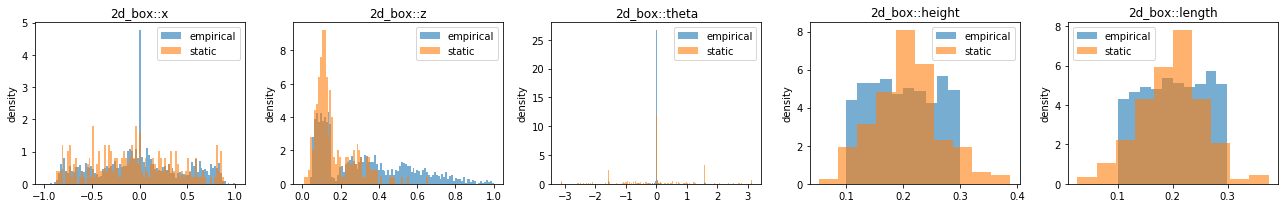

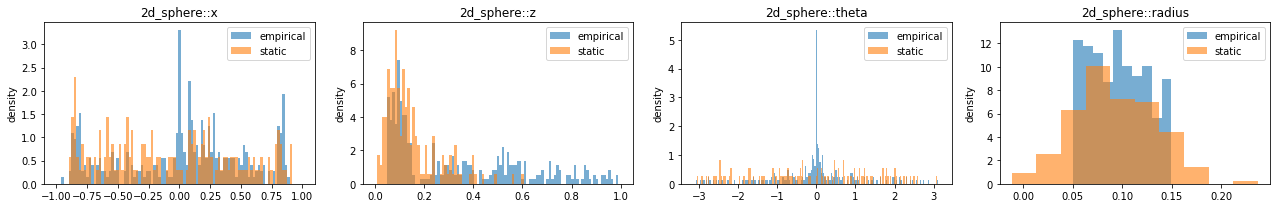

In [21]:
for object_name in params_by_object_class.keys():
    object_id = scenes_dataset.class_name_to_id[object_name]
    plt.figure().set_size_inches(18, 3)
    
    param_sets_base = [
        params_by_object_class[object_name],
        #params_by_object_class_nonpen[object_name],
        params_by_object_class_static[object_name]
    ]
    #params_sets_names = ["empirical", "nonpenetrating", "static"]
    params_sets_names = ["empirical", "static"]
    
    param_sets = []
    for params in param_sets_base:
        params_stacked = np.stack(params).copy()
        #params_stacked[:, 2] = ((params_stacked[:, 2] + 2 * np.pi) % (2 * np.pi) - np.pi)
        param_sets.append(params_stacked)

    for k in range(param_sets[0].shape[1]):
        if k >= 3:
            param_name = scenes_dataset.params_names_by_class[object_id][k - 3]
        else:
            param_name = ["x", "z", "theta"][k]
        plt.subplot(1, param_sets[0].shape[1], k+1)
        plt.title(object_name + "::" + param_name)
        plt.ylabel("density")
        bins = None
        if k == 0:
            bins = np.linspace(-1., 1., 100)
        elif k == 1:
            bins = np.linspace(0., 1., 100)
        elif k == 2:
            bins = np.linspace(-np.pi, np.pi, 200)
        for i, params in enumerate(param_sets):
            x_bins = plt.hist(params[:, k], label=params_sets_names[i], density=True, bins=bins, alpha=0.6)[1]
        x_range = np.linspace(x_bins[0], x_bins[-1], 100)
        plt.legend()
        
    plt.tight_layout()